In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import matplotlib.image as mpimg
import pycolmap
from pathlib import Path
from src.geometry.point_transformation import *

### Gaussian Function
Gaussian is defined by a mean $\mu$ and, in case of 2D, by 2x2 covariance matrix 

In [5]:
white_data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=1000)

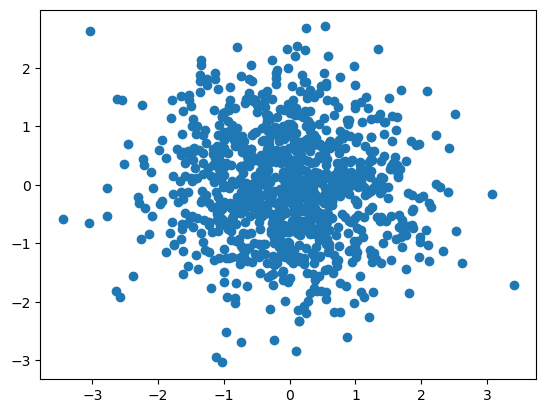

In [6]:
plt.scatter(white_data[:, 0], white_data[:, 1])

For eigenvectors and eigenvalues of a matrix $A$ it is true that 

$$A v = \lambda v$$

where $v$ is an eigenvector and $\lambda$ is a corresponding eigenvalue

In [7]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

v = eigenvectors[:, 0]
lambd = eigenvalues[0]

lhs = cov @ v 
rhs = lambd * v

print(f"LHS = {lhs}")
print(f"RHS = {rhs}")
print(np.allclose(lhs, rhs))

LHS = [3.53553391 3.53553391]
RHS = [3.53553391 3.53553391]
True


If we have white data $D$ defined as above, then we can apply a transformation $T$ consisting of rotation $R$ and scaling $S$ ($T = RS$) to get new data $D'$. It relates covariance matrix as follows $$\Sigma = TIT^{T}$$ $$\Sigma = RS(RS)^{T}$$ $$\Sigma = RSS^TR^T$$

How does it relate to eigenvalues & eigenvectors?

$$\Sigma V = V L$$ where $V$ is a matrix of eigenvectors and $L$ is a diagonal matrix of eigenvalues

$$\Sigma = V L V^{-1}$$

It is the eigendecomposition of the covariance matrix, where $R = V$ and $S = \sqrt{L}$

In [8]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [9]:
eigenvalues

array([5., 1.])

In [10]:
eigenvectors

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [11]:
R = eigenvectors
S = np.sqrt(np.diag(eigenvalues))
print(R)
print(S)
new_cov = R @ S @ S.T @ R.T
print(new_cov)
np.allclose(new_cov, cov) # same as original one

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]
[[3. 2.]
 [2. 3.]]


True

In [12]:
U, M, V = LA.svd(cov)
M = np.sqrt(np.diag(M))

In [13]:
print(U)
print(M)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]


In [14]:
np.allclose(new_cov, cov) # same as original one

True

In [15]:
transformed_data = white_data @ S @ R.T

In [16]:
transformed_data

array([[-0.52956709,  2.166851  ],
       [ 3.34092463,  2.35125915],
       [-2.47825495, -2.05921056],
       ...,
       [ 1.03741716,  0.67146529],
       [ 0.79640018,  1.57683762],
       [-0.74987035, -2.08156569]])

In [17]:
data = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=1000)

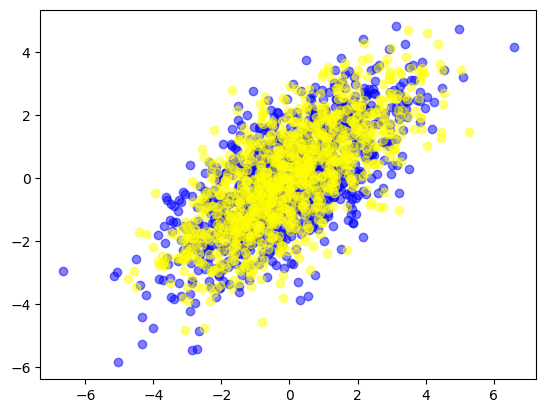

In [18]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5, color='blue')
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')

### Projecting 3D Covariance onto 2D 

In general, if we want to apply $V$ transformation to a covariance matrix $\Sigma$, then 

$$\Sigma' = V \Sigma V^{T}$$

In [29]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'

reconstruction = pycolmap.Reconstruction(scene_folder / '0')
camera = reconstruction.cameras[1]
img_id = 1
img = reconstruction.images[img_id]
img_name = img.name

In [30]:
width, height = camera.width, camera.height

In [31]:
img_points, colors = projection_from_reconstruction(reconstruction, img_id)
points, colors = filter_view_points(img_points, colors, width, height)

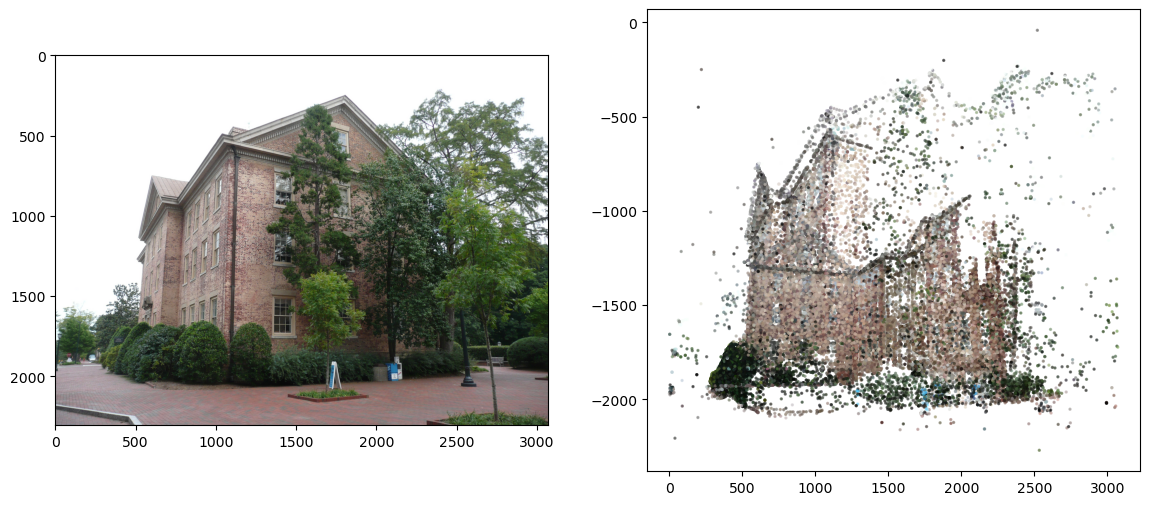

In [36]:
image = mpimg.imread(images_folder / f'{img_name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.scatter(points[:, 0], -points[:, 1], alpha=0.5, c=colors, s=2)

In [37]:
extrinsic_params = get_extrinsic_params(get_camera_from_image(img))
print(extrinsic_params)

[[ 0.46293486  0.25750281  0.84816485 -0.67305164]
 [-0.22869221  0.95917486 -0.16638349  0.96543814]
 [-0.85638262 -0.11694397  0.50292436  3.60088536]
 [ 0.          0.          0.          1.        ]]


In [38]:
viewing_transformation = extrinsic_params[:3, :3].T # LA.inv(extrinsic_params[:3, :3])
viewing_transformation

array([[ 0.46293486, -0.22869221, -0.85638262],
       [ 0.25750281,  0.95917486, -0.11694397],
       [ 0.84816485, -0.16638349,  0.50292436]])

In [39]:
cov3D = np.array([[1, 2, 3], [2, 3, 2], [1, 1, 1]])

Viewing transformation is used to transform from object space to camera coordinates

In [40]:
variance_in_camera_coordinates = viewing_transformation @ cov3D @ viewing_transformation.T
variance_in_camera_coordinates

array([[-0.31713151, -0.81928403, -0.58131742],
       [-2.00021586,  3.37103093,  2.49577456],
       [-2.24216432,  1.57545529,  1.94610057]])

### Perspective Projection

In perspective projection, a 3D point in a truncated pyramid frustum (eye coordinates) is mapped to a cube (NDC).

<div>
<img src="images/gl_projectionmatrix01.png" width="500">
</div>

A 3D point is projected onto **near** plane in eye space (2D). The following show how point $(x_e, y_e, z_e)$ is projected to $(x_p, y_p, z_p)$ on the near space.

<div>
<img src="images/gl_projectionmatrix03.png" width="500">
<img src="images/gl_projectionmatrix04.png" width="500">
</div>

Using the ratio of similar triangles, we calculate:

$$x_p = \frac{n * x_e}{-z_e}$$
$$y_p = \frac{n * y_e}{-z_e}$$
$$z_p = -n$$

However, this transformation can't be represented by 3x3 matrix so we'll need to use it's approximation. We'll need to find Jacobian matrix 

$$ J = \begin{pmatrix}
 \frac{x_p}{x_e} & \frac{y_p}{x_e} & \frac{z_p}{x_e} \\
 \frac{x_p}{y_e} & \frac{y_p}{y_e} & \frac{z_p}{y_e} \\
 \frac{x_p}{z_e} & \frac{y_p}{z_e} & \frac{z_p}{z_e} 
 \end{pmatrix}
 $$
 
$$J = \begin{pmatrix} 
\frac{-n}{z_e} & 0 & 0 \\
0 & -\frac{n}{z_e} & 0 \\
\frac{nx_e}{z_e^{2}} & \frac{ny_e}{z_e^{2}} & 0
\end{pmatrix}$$

In [41]:
def get_jacobian_matrix(point: np.array, znear):
    J = np.zeros((3, 3))
    J[0, 0] = -znear / point[2]
    J[1, 1] = -znear / point[2]
    J[2, 0] = point[0] / point[2] ** 2
    J[2, 1] = point[1] / point[2] ** 2
    return J 

In [44]:
p = img_points[1, :]

In [45]:
get_jacobian_matrix(p, 0.1)

IndexError: index 2 is out of bounds for axis 0 with size 2